In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
sys.path.append(os.getcwd() + '/../../')

from matplotlib.patches import Ellipse
from numpy.random import multivariate_normal as m_normal
import plda
from scipy.stats import norm, chi2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [2]:
import numpy as np
#from PLDA import PLDA
from numpy.random import multivariate_normal as m_normal

from scipy.linalg import eig
from scipy.linalg import inv
from scipy.stats import linregress

In [17]:
def gen_Ψ(n_dims):
    """ Diagonal matrix describing the covariance between clusters.
    """
    Ψ = np.diag(10 / np.random.sample(n_dims))

    return Ψ

def gen_m(n_dims):
    """ Displacement of the mean of the data from the origin.
    """
    m = np.random.randint(-10, 10, n_dims).astype(float)

    return m

def gen_V(Ψ, n_classes, n_dims):
    """ v ~ N(0, Ψ): Consult Equations (2) on p. 533.

    DESCRIPTION: Samples whitened class centers from a multivariate
                  Gaussian distribution centered at 0, with covariance Ψ.
                  For testing purposes, we ensure that V.sum(axis=0) = 0. 

    PARAMETERS
     n_classes      (int): Number of classes.
     n_dims         (int): Dimensionality of the data.
     Ψ        (ndarray): Covariance between whitened class centers.
                            [n_dims x n_dims] 
    RETURNS
     V          (ndarray): Whitened class centers. [n_classes x n_dims] 
    """
    assert Ψ.shape[0] == Ψ.shape[1]

    μ = np.zeros(n_dims)  # [1 x n_dims] 
    np.random.seed(0)
    V = m_normal(μ, Ψ, n_classes)
    V = V - V.mean(axis=0)  # Center means at origin to control result.


    assert np.allclose(V.sum(axis=0), 0)

    return V

def gen_A(V, n_classes, n_dims, return_S_b=False):
    # XXX Where this eq come from
    """ A = [B][inv(Λ ** .5)][Q^T] and assumes same number of data
         in each class v. """
    
    
    #np.random.seed(2018)
    B = np.random.randint(-200, 200, (n_dims, n_dims)).astype(float)
    big_V = np.matmul(V.T, V)  # V is now a scatter matrix.
    vals, vecs = eig(big_V)
    A = B / np.sqrt(vals.real)
    A = np.matmul(A, vecs.T)
    
    # XXX It works as well does not need to be that eq. But Why is he doing that? !?
    #A = B
    
    D = np.matmul(np.matmul(vecs.T, big_V), vecs)
    assert np.allclose(D, np.diag(vals))
    
    if return_S_b is True:
        
        # XXX Where this eq come from
        S_b = 1 /n_classes * np.matmul(np.matmul(A, big_V), A.T)
        x = np.matmul(A, V.T).T

        S_b_empirical = 1 / n_classes * np.matmul(x.T, x)
        assert np.allclose(S_b, S_b_empirical)

        return A, S_b
    else:
        return A

def gen_U(n_dims, n, V):
    """ u ~ N(v, I). 533.
    """
    cov = np.eye(n_dims)

    U = []
    for v in V:
        μ = np.zeros(n_dims)
        U_for_class_v = m_normal(μ, cov, n)
        U_for_class_v -= U_for_class_v.mean(axis=0)
        U_for_class_v += v  # Center at v to control test results.
        U.append(U_for_class_v)

    # To control the test result, each set of u's sums to its respective v.
    for x in range(len(U)):
        are_same = np.allclose(V[x], U[x].mean(axis=0))
        assert are_same ==  True

    U = np.vstack(U)

    return U

def unwhiten(U, A, m):
    """ inv(A)[x - m]. See p. 537 Fig. 2.
    """
    X = np.matmul(A, U.T).T
    X += m

    return X

def gen_labels(n_classes, n):
    labels = []
    for x in range(n_classes):
        labels += [x] * n

    return labels

def label(data, labels):
    labeled_data = []
    for datum, label in zip(data, labels):
        labeled_data.append((datum, label))
        
    return labeled_data

def experiment(n, n_dims, n_classes):

    Ψ = gen_Ψ(n_dims)
    m = gen_m(n_dims)
    V = gen_V(Ψ, n_classes, n_dims)
    U = gen_U(n_dims, n, V)
    A, S_b = gen_A(V, n_classes, n_dims,
                             return_S_b=True)
    X = unwhiten(U, A, m)
    Y = gen_labels(n_classes, n)
    labels = []
    for k in range(0,n_classes):
        labels += [k]*n
 
    classifier = plda.Classifier(X, np.array(labels))
    classifier.fit_model()

    return A, Ψ,classifier.model

In [5]:
n_dims = 2

Psi = gen_Ψ(n_dims)
m = gen_m(n_dims)

Psi
m

array([[128.61172724,   0.        ],
       [  0.        , 185.30473375]])

array([6., 7.])

In [6]:
n = 100
n_classes = 3 

V = gen_V(Psi, n_classes, n_dims)
A, Sb = gen_A(V, n_classes, n_dims, return_S_b=True)
U = gen_U(n_dims, n, V)

V
V.shape

U.shape
A


array([[ -1.75138722,   3.09374527],
       [ 19.12386778,  -7.59647852],
       [-17.37248056,   4.50273325]])

(3, 2)

(300, 2)

array([[ -9.55137473, -37.91257083],
       [-17.10153281, -34.93773515]])

In [7]:
Y = unwhiten(V, A, m)

Y

X = unwhiten(U, A, m)
X.shape

array([[-94.56368097, -71.13704678],
       [111.34280263, -54.64369752],
       [  1.22087834, 146.7807443 ]])

(300, 2)

(-22.238233360003605,
 23.80575477479957,
 -11.432751889069955,
 8.192036369183855)

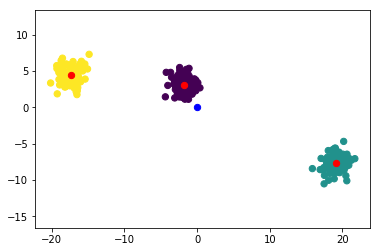

In [9]:
U_labels = ([1] * 100) + ([2] * 100) + ([3] * 100)

ax = plt.gca()
ax.scatter(U[:, 0], U[:, 1], c=U_labels, s=40, cmap='viridis', zorder=2)
ax.scatter(V[:, 0], V[:, 1], c='red', s=40, cmap='viridis', zorder=2)
ax.scatter(0, 0, c='blue', s=40, cmap='viridis', zorder=2)
ax.axis('equal')

(-207.89961064885154,
 259.4138277876043,
 -196.31258445024238,
 293.37533914267993)

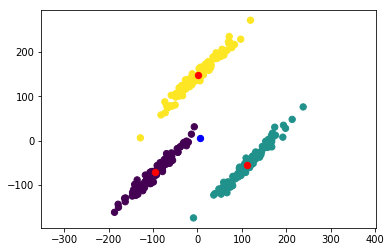

In [10]:
ax = plt.gca()
ax.scatter(X[:, 0], X[:, 1], c=U_labels, s=40, cmap='viridis', zorder=2)
ax.scatter(Y[:, 0], Y[:, 1], c='red', s=40, cmap='viridis', zorder=2)
ax.scatter(m[0], m[1], c='blue', s=40, cmap='viridis', zorder=2)
ax.axis('equal')

In [11]:
classifier = plda.Classifier(X, np.array(U_labels))
classifier.fit_model()

In [12]:
model_mk, labels1 = classifier.model.get_means(return_labels=True)
model_ns, labels2 = classifier.model.get_ns(return_labels=True)
model_covs, labels3 = classifier.model.get_covs(return_labels=True)

model_ns

Y
model_mk

model_m = classifier.model.calc_m(model_mk,model_ns,300)

m
model_m

model_Sw = classifier.model.S_w
model_Sb = classifier.model.S_b

Sb
model_Sb

model_W = classifier.model.calc_W(model_Sw, model_Sw)
model_W

Lambda_w = classifier.model.calc_Λ_w(model_Sw, model_W)
Lambda_b = classifier.model.calc_Λ_b(model_Sw, model_W)

model_A = classifier.model.calc_A(n, Lambda_w, model_W)

A
model_A 

[100, 100, 100]

array([[-94.56368097, -71.13704678],
       [111.34280263, -54.64369752],
       [  1.22087834, 146.7807443 ]])

[array([-94.56368097, -71.13704678]),
 array([111.34280263, -54.64369752]),
 array([  1.22087834, 146.7807443 ])]

array([6., 7.])

array([6., 7.])

array([[7077.66666667,  232.        ],
       [ 232.        , 9814.66666667]])

array([[7077.66666667,  232.        ],
       [ 232.        , 9814.66666667]])

array([[-0.01341884, -0.12232308],
       [-0.01109092,  0.12233377]])

array([[ -9.55137473, -37.91257083],
       [-17.10153281, -34.93773515]])

array([[-41.00724913,  -3.71776264],
       [-41.00366396,   4.49810079]])

In [13]:
model_Phi_w = np.matmul(model_A,model_A.T)

model_Phi_w
n/(n-1)*model_Sw

Phi_w = np.matmul(A,A.T)
Phi_w

(Phi_w - model_Phi_w)/Phi_w

X1 = X[0:100,:]
X2 = X[100:200,:]
X3 = X[200:300,:]

print('S1')
S1 = np.cov(X1[:,0],X1[:,1])
S1

print('S2')
S2 = np.cov(X2[:,0],X2[:,1])
S2

print('S3')
S3 = np.cov(X3[:,0],X3[:,1])
S3

print('AVG: (S1 + S2 + S3)/3')
(S1 + S2 + S3)/3

print('Sww')
Sww = ((S1 + S2 + S3)/300)*n/(n-1)
Sww

array([[1695.41623986, 1664.7245922 ],
       [1664.7245922 , 1701.53336922]])

array([[1695.41623986, 1664.7245922 ],
       [1664.7245922 , 1701.53336922]])

array([[1528.59178631, 1487.92250696],
       [1487.92250696, 1513.10776194]])

array([[-0.10913604, -0.11882479],
       [-0.11882479, -0.12452887]])

S1


array([[1438.79074765, 1392.84904842],
       [1392.84904842, 1412.67309989]])

S2


array([[1745.01363625, 1746.66192031],
       [1746.66192031, 1810.52705648]])

S3


array([[1902.44433569, 1854.66280788],
       [1854.66280788, 1881.39995128]])

AVG: (S1 + S2 + S3)/3


array([[1695.41623986, 1664.7245922 ],
       [1664.7245922 , 1701.53336922]])

Sww


array([[17.12541656, 16.81539992],
       [16.81539992, 17.18720575]])

In [18]:
n_experiments = int(np.log10(1000000) / 2)
n_experiments

n_list = [100 ** x for x in range(1, n_experiments + 1)]
n_list = np.array(n_list).astype(float)

n_list

n_dims 
n_classes = 30 #self.n_classes

Φ_w_L1_errors = []
for n in n_list:
    A, Ψ, model = experiment(int(n), n_dims, n_classes)

    Φ_w = np.matmul(A, A.T)
    Φ_w_model = np.matmul(model.A, model.A.T)

    L1_error = np.abs(Φ_w - Φ_w_model).mean()
    abs_μ = (np.abs(Φ_w).mean() + np.abs(Φ_w_model).mean()) * .5
    percent_error = L1_error / abs_μ * 100
    
    print('Testing Φ_w with {} samples: {} percent error'.format(n,
          percent_error))
    
    Φ_w_L1_errors.append(percent_error)

Y = Φ_w_L1_errors
X = [x for x in range(len(Φ_w_L1_errors))]
slope_of_error_vs_N = linregress(X, Y)[0]

3

array([1.e+02, 1.e+04, 1.e+06])

2

Testing Φ_w with 100.0 samples: 3.6904703920462043 percent error
Testing Φ_w with 10000.0 samples: 0.5633831629357423 percent error
Testing Φ_w with 1000000.0 samples: 0.01870634434343993 percent error


array([1.e+02, 1.e+04, 1.e+06])

array([2., 4., 6.])

[3.6904703920462043, 0.5633831629357423, 0.01870634434343993]

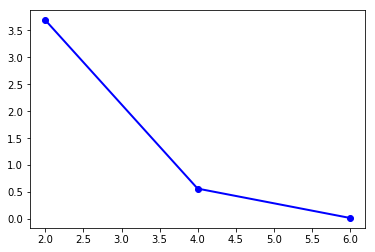

In [27]:

n_list
np.log10(n_list)
Φ_w_L1_errors

# ax = plt.gca()
# ax.lines.(np.array(n_list), Φ_w_L1_errors)
plt.plot(np.log10(n_list), Φ_w_L1_errors, 'bo-', label='line 1', linewidth=2)